Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-rc0'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Build a lines segmentation model based on unet architecture 

Here is [the paper](https://arxiv.org/pdf/1505.04597.pdf)

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())  # Source: https://github.com/fastai/fastai/blob/master/fastai/core.py#L236

from tqdm import tqdm

from PIL import Image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [4]:
from recognizer.datasets import Dataset
from recognizer.networks import unet
from recognizer.networks import unet_mini
from recognizer.networks import fcn
from recognizer.networks import NetworkInput

In [5]:
lines_detector_path = Dataset.processed_data_path()/"lines_detector"
lines_detector_images_path = lines_detector_path/"images"
lines_detector_masks_path = lines_detector_path/"masks"

Hyperparameters

In [6]:
batch_size = 4
epochs = 5

number_of_classes = 3

In [7]:
model_save_path = Path("../recognizer/weights/lines_detector.h5")

## Load dataset

In [8]:
x = []
y = []

sorted_image_names = sorted(lines_detector_images_path.glob("*.jpg"))
sorted_mask_names = sorted(lines_detector_masks_path.glob("*.png"))
for image_file_name, mask_file_name in tqdm(zip(sorted_image_names, sorted_mask_names)):
    image = img_to_array(Image.open(image_file_name))  # / 255
    mask = img_to_array(Image.open(mask_file_name), dtype=np.uint8) // 127
    
    x.append(image)
    y.append(mask)

x = np.array(x)
y = np.array(y)

# len(x), x[0].shape
x.shape

1539it [00:02, 613.39it/s]


(1539, 256, 256, 1)

In [9]:
x[0].dtype, y[0].dtype

(dtype('float32'), dtype('uint8'))

In [10]:
np.min(x), np.max(x)

(0.0, 1.0)

Prepare the data for training

In [ ]:
np.unique(y)

In [ ]:
# x = (x - np.mean(x)) / np.std(x)
x /= 255
y = to_categorical(y, number_of_classes)

np.min(x), np.max(x), y.shape

## Augment the data

## Build the model

array([0, 1, 2], dtype=uint8)

(-7.98992, 0.4018042, (1539, 256, 256, 3))

In [13]:
input_shape = x[0].shape
# model = unet_mini(
# model = unet(
model = fcn(
    NetworkInput(input_shape=input_shape, number_of_classes=number_of_classes)
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

## Train the model

Check progress in TensorBoard by running tensorboard --logdir=logs/lines_detector_model in terminal

In [14]:
# Try removing the old logs first
!rm -r ../logs/lines_detector_model

callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/lines_detector_model')
]

In [15]:
model.compile(optimizer=Adam(lr=1e-2),  # RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(
    x,
    y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=.2,
    shuffle=True
)
history.history.keys()

Train on 1231 samples, validate on 308 samples
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1231/1231 [==============================] - 767s 623ms/sample - loss: 0.7445 - accuracy: 0.6587 - val_loss: 0.5847 - val_accuracy: 0.7105
Epoch 2/5
1231/1231 [==============================] - 778s 632ms/sample - loss: 0.5717 - accuracy: 0.7202 - val_loss: 0.5500 - val_accuracy: 0.7170
Epoch 3/5
 204/1231 [===>..........................] - ETA: 10:59 - loss: 0.5549 - accuracy: 0.7226

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# Save the model

In [ ]:
model.save(model_save_path)

## Restore the model

In [ ]:
model = keras.models.load_model(model_save_path)

model.trainable = False
model.compile(optimizer=Adam(lr=1e-2),  # RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.trainable_variables

## Predict on one image

In [17]:
image_array = x[0]
test_batch = image_array.reshape((1,) + image_array.shape)

preds = model.predict(test_batch)
preds.shape

(1, 256, 256, 3)

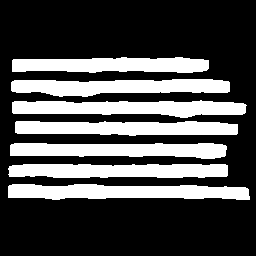

In [18]:
# Merge the 3 channel classes into one for color
pred_image_array = np.expand_dims(np.argmax(preds[0], axis=2), axis=-1)
array_to_img(pred_image_array)

In [19]:
np.min(preds[0]), np.max(preds[0])

(-183813900.0, 7056875500.0)

In [20]:
np.min(pred_image_array), np.max(pred_image_array)

(0, 1)

In [21]:
np.argmax(preds[0], axis=1).shape

(256, 3)

In [22]:
np.argmax(preds[0], axis=2).shape

(256, 256)

In [23]:
np.expand_dims(np.argmax(preds[0], axis=2), axis=-1).shape

(256, 256, 1)

In [24]:
pred_image_array.shape

(256, 256, 1)

Check predication array

In [25]:
for row in preds[0]:
    if np.max(row) > 0:
        print(row)

[[ 4.44502200e+07  1.07490712e+06 -2.01915775e+06]
 [ 7.79907680e+07  1.92115025e+06 -3.63321475e+06]
 [ 1.03660992e+08  2.51007975e+06 -4.86151150e+06]
 [ 1.19951312e+08  2.93835200e+06 -5.69079350e+06]
 [ 1.35878448e+08  3.30246325e+06 -6.47374950e+06]
 [ 1.44200416e+08  3.52126775e+06 -6.89320550e+06]
 [ 1.49855584e+08  3.65856200e+06 -7.16366400e+06]
 [ 1.51369568e+08  3.70379675e+06 -7.23268900e+06]
 [ 1.52373728e+08  3.73918275e+06 -7.27872950e+06]
 [ 1.52736912e+08  3.75322525e+06 -7.29729750e+06]
 [ 1.52780592e+08  3.76032075e+06 -7.30212200e+06]
 [ 1.52647344e+08  3.75897500e+06 -7.29609550e+06]
 [ 1.52232480e+08  3.75269375e+06 -7.27797700e+06]
 [ 1.51905536e+08  3.74575550e+06 -7.26270650e+06]
 [ 1.51638400e+08  3.74087300e+06 -7.25102650e+06]
 [ 1.51556096e+08  3.73880725e+06 -7.24695500e+06]
 [ 1.51451984e+08  3.73663675e+06 -7.24197450e+06]
 [ 1.51391120e+08  3.73518200e+06 -7.23889800e+06]
 [ 1.51355376e+08  3.73451450e+06 -7.23717550e+06]
 [ 1.51355056e+08  3.73450850e+

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
np.argmax(preds[0], axis=2).shape

(256, 256)

In [27]:
for row in np.argmax(preds[0], axis=2):
    if np.max(row) > 0:
        print(row)
    else:
        print(">> EMPTY ROW <<")

>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 

Check target array

In [ ]:
for row in y[0]:
    if np.max(row) > 0:
        print(row)

In [ ]:
np.argmax(y[0], axis=2).shape

In [ ]:
for row in np.argmax(y[0], axis=2):
    if np.max(row) > 0:
        print(row)
    else:
        print(">> EMPTY ROW <<")